# Cosmology Computational Project
## Analysis-1 Compare CMB power spectrum of Theory and data
in this notebook, I'll walk through the analysis of the ACT_DR5_f150 map, the first thing we want to do is to compare the power spectrum of theory and real data. This follow the Summer school notebook 6-7 

In [1]:
!python -c "import cmb_modules" || ( \
    wget https://github.com/jeffmcm1977/CMBAnalysis_SummerSchool/raw/master/cmb_school.tar.gz && \
    tar xzvf cmb_school.tar.gz \
)

# Import constants and define variables

In [2]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

import constants as cs # the constants module
import cmb_modules # the module of functions

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = cs.atmospheric_noise_level
one_over_f_noise_level = cs.one_over_f_noise_level

# Import ACT_DR5 data and define the pixel size according to header 

In [3]:
map = fits.getdata('/Users/yi/Documents/CMB_SZ/act_dr5.01_s08s18_AA_f150_daynight_map.fits')
header = fits.getheader('/Users/yi/Documents/CMB_SZ/act_dr5.01_s08s18_AA_f150_daynight_map.fits')
ra0 = -180  ## Sky ccoverage of DR5
ra1 = 180
dec0 = -63
dec1 = 23
Nx= header['NAXIS1']
Ny= header['NAXIS2']
Box_side = 500     # this is the size of the map patches 

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins

map = map[0]

0.5 0.5


In [4]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                43200                                                  
NAXIS2  =                10320                                                  
NAXIS3  =                    3                                                  
CRPIX1  =              21601.0 / Pixel coordinate of reference point            
CRPIX2  =               7561.0 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
CDELT1  =  -0.0083333333333333 / [deg] Coordinate increment at reference point  
CDELT2  =   0.0083333333333333 / [deg] Coordinate increment at reference point  
CDELT3  =                  1.0 / Coordinate increment at reference point        
CUNIT1  = 'deg'             

# plotting the DR5 map

map mean: -0.79496956 map rms: 162.88133


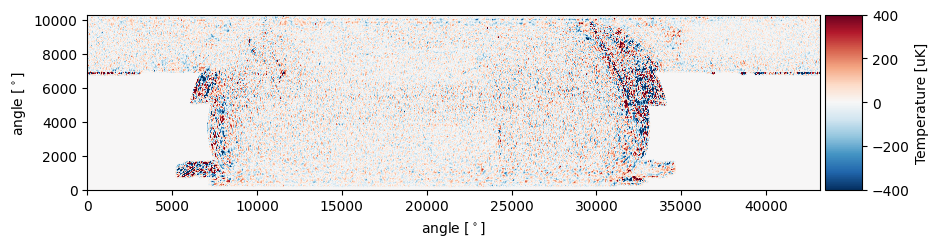

In [5]:
plt.figure(figsize=(20,20))
p = cmb_modules.Plot_CMB_Map(map,c_min,c_max,Nx,Ny)

# Cutting map patches and make a appodized map 

In [6]:
N=int(500) # take only one dimension
map_patch = map[N:2*int(N), Ny-2*N:Ny-N] #trimming the map down to size

map mean: -1.9485154749790254 map rms: 61.421140056313476


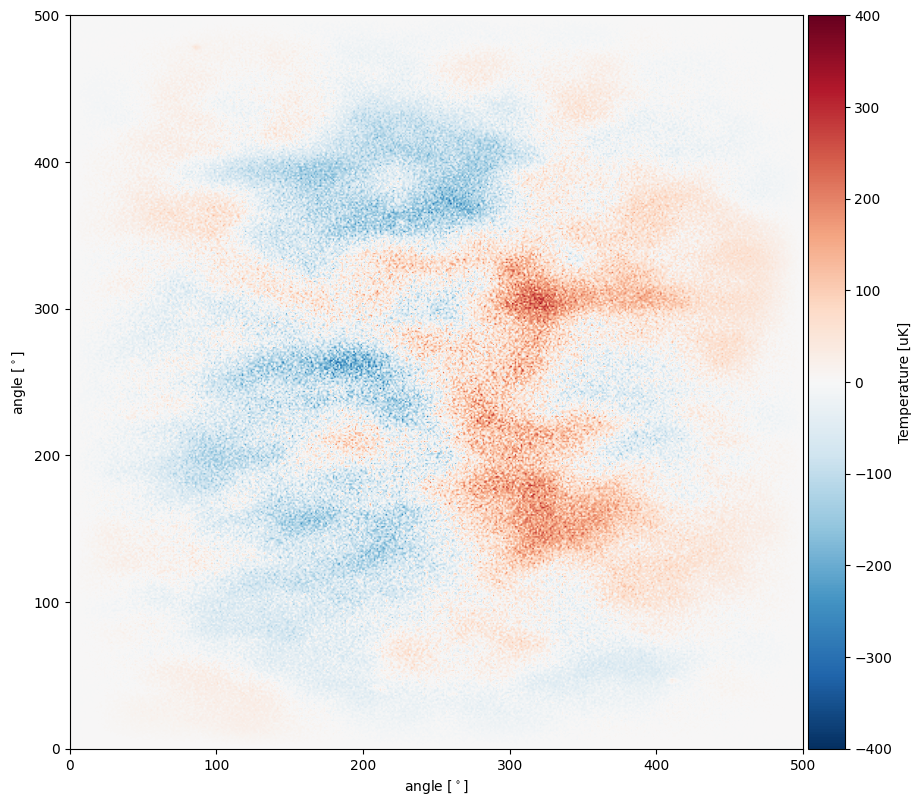

In [7]:
# Making a window function, taking the shorter dimension for now
window = (cmb_modules.cosine_window(N))
appodized_map = window * map_patch
p=cmb_modules.Plot_CMB_Map(appodized_map,c_min,c_max,N, N)

# Get a modeled CMB map with point source, SZ map, noise, and convoled with insrument beam

/Users/yi/Documents/GitHub/Cosmology_Technical_project/cmb_modules.py:15: RuntimeWarning: invalid value encountered in divide
  ClTT = DlTT * 2 * np.pi / (ell * (ell + 1.0))


Number of sources required:  5000
map mean: -33.313089310930216 map rms: 57.49093642473847


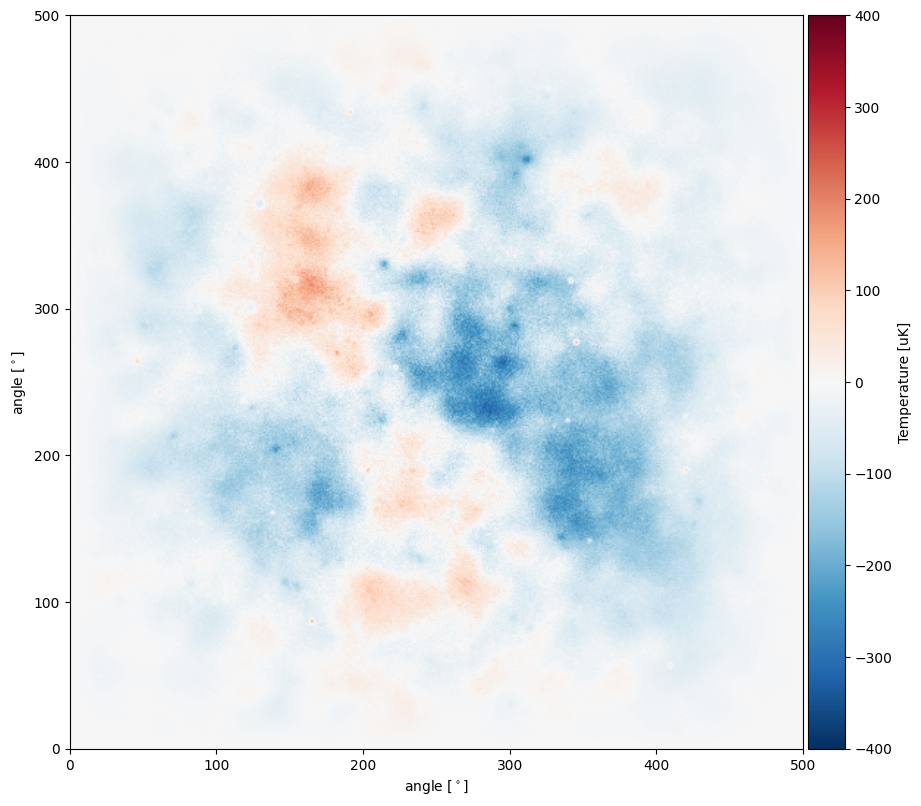

In [8]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 

CMB_T = cmb_modules.make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = cmb_modules.Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap += cmb_modules.Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = cmb_modules.SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorperate the impact of the instrument
    ## beam
CMB_T_convolved = cmb_modules.convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise
Noise = cmb_modules.make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

## plot the result
#p = cmb_modules.Plot_CMB_Map(total_map_plus_noise,c_min,c_max,N,N)

appodized_theory_map = window * total_map_plus_noise

p = cmb_modules.Plot_CMB_Map(appodized_theory_map,c_min,c_max,N, N)

# Calculate the auto-correlation power spectrum of CMB data and theory 

/opt/anaconda3/envs/my_x86_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/my_x86_env/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


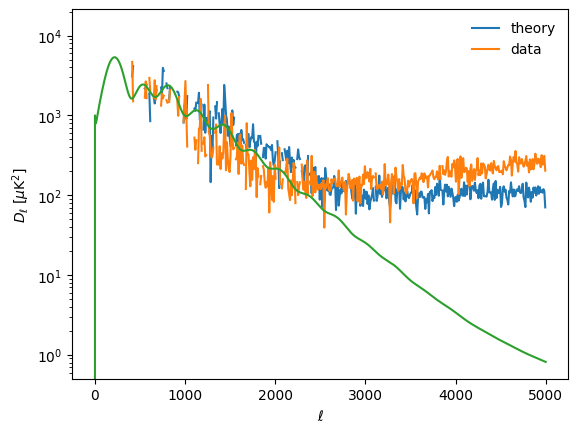

In [9]:
#### parameters for setting up the spectrum
delta_ell = 10# cs.delta_ell
ell_max = cs.ell_max
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')
        
binned_ell_theory, binned_spectrum_theory = \
    cmb_modules.calculate_2d_spectrum(appodized_theory_map,appodized_theory_map,delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    cmb_modules.calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='theory')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='data')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

# first expansion of this note book is I want to quantify the discrepancy of the theory and data by using curvefit and $\chi^2$.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

In [58]:
def fit_and_resample_cubic(ell_data, C_l_data, ell_theory, C_l_theory, num_points=100):
    """
    Fits the theoretical model to the observed data using cubic interpolation,
    resamples both datasets to have the same shape, and calculates the Chi-squared statistic.
    
    Parameters:
    - ell_data: Multipole moments for the observed data.
    - C_l_data: Observed power spectrum values.
    - ell_theory: Multipole moments for the theoretical model.
    - C_l_theory: Theoretical power spectrum values.
    - num_points: Number of points for resampling.
    
    Returns:
    - resampled_ell: Resampled ell values.
    - resampled_C_l_data: Resampled observed spectrum.
    - resampled_C_l_fit: Fitted theoretical spectrum.
    - chi_squared: Chi-squared statistic.
    - popt: Optimal parameters from curve fitting.
    """
    # Step 1: Clean the input data by removing NaNs and Infs
    valid_data_indices = np.isfinite(ell_data) & np.isfinite(C_l_data)
    ell_data = ell_data[valid_data_indices]
    C_l_data = C_l_data[valid_data_indices]
    
    valid_theory_indices = np.isfinite(ell_theory) & np.isfinite(C_l_theory)
    ell_theory = ell_theory[valid_theory_indices]
    C_l_theory = C_l_theory[valid_theory_indices]
    
    # Ensure there's data left after cleaning
    if len(ell_data) == 0 or len(ell_theory) == 0:
        raise ValueError("Cleaned data has no valid entries.")
    
    # Step 2: Define the range for resampling
    min_ell = max(min(ell_data), min(ell_theory))
    max_ell = min(max(ell_data), max(ell_theory))
    resampled_ell = np.linspace(min_ell, max_ell, num_points)
    
    degree = 3
    theory_coeff = np.polyfit(np.log(ell_theory), np.log(C_l_theory), degree)
    data_coeff = np.polyfit(np.log(ell_data), np.log(C_l_data), degree)
    # Generate the polynomial function
    theory_poly = np.poly1d(theory_coeff)
    data_poly = np.poly1d(data_coeff)
    resampled_C_l_fit_log = theory_poly(np.log(resampled_ell))
    resampled_C_l_data_log= data_poly(np.log(resampled_ell))
    
    resampled_C_l_fit = np.exp(resampled_C_l_fit_log)
    resampled_C_l_data= np.exp(resampled_C_l_data_log)


    # Step 8: Calculate the Chi-squared statistic
    chi_squared = np.sum(((resampled_C_l_data - resampled_C_l_fit) ** 2) / resampled_C_l_fit)
    
    return resampled_ell, resampled_C_l_data, resampled_C_l_fit, chi_squared


In [59]:
resampled_ell, resampled_C_l_data, resampled_C_l_fit, chi2= fit_and_resample_cubic(binned_ell_dat, binned_spectrum_dat, binned_ell_theory, binned_spectrum_theory, num_points=1000)

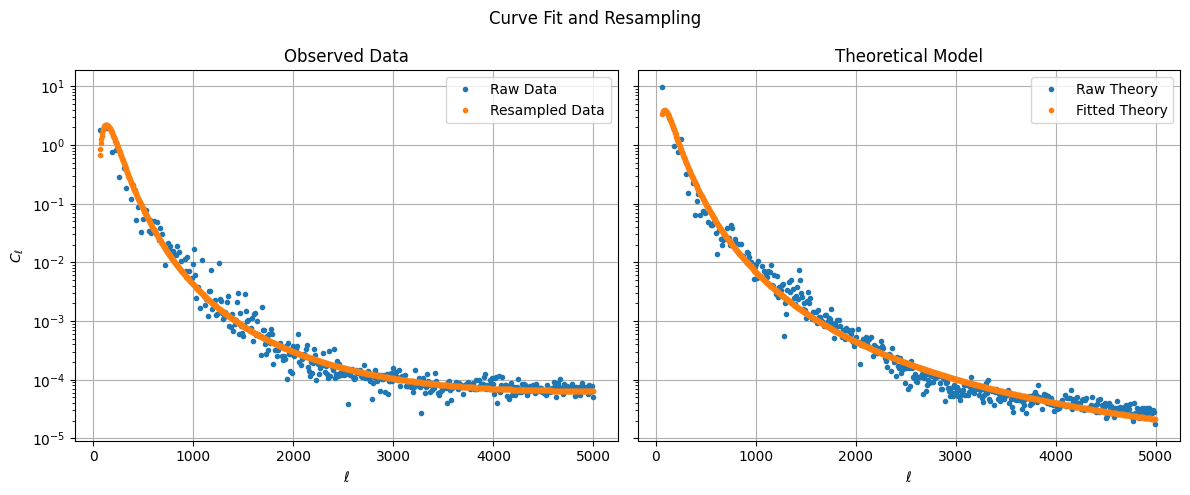

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot 1: Observed data
ax1.semilogy(binned_ell_dat, binned_spectrum_dat, '.', label='Raw Data')
ax1.semilogy(resampled_ell, resampled_C_l_data, '.', label='Resampled Data')
ax1.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$C_\ell$')
ax1.set_title('Observed Data')
ax1.legend()
ax1.grid(True)

# Plot 2: Theoretical model
ax2.semilogy(binned_ell_theory, binned_spectrum_theory, '.', label='Raw Theory')
ax2.semilogy(resampled_ell, resampled_C_l_fit, '.', label='Fitted Theory')
ax2.set_xlabel(r'$\ell$')
ax2.set_title('Theoretical Model')
ax2.legend()
ax2.grid(True)

# Adjust layout and show the plots
plt.suptitle('Curve Fit and Resampling')
plt.tight_layout()
plt.show()

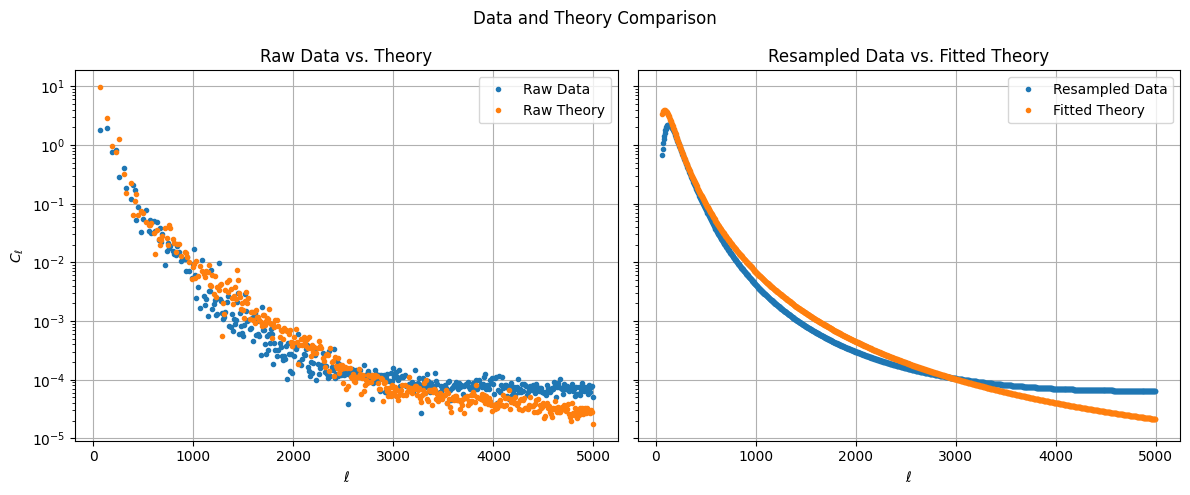

In [65]:
import matplotlib.pyplot as plt

# Create a figure with two subplots arranged side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot 1: Raw data vs. raw theory
ax1.semilogy(binned_ell_dat, binned_spectrum_dat, '.', label='Raw Data')
ax1.semilogy(binned_ell_theory, binned_spectrum_theory, '.', label='Raw Theory')
ax1.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$C_\ell$')
ax1.set_title('Raw Data vs. Theory')
ax1.legend()
ax1.grid(True)

# Plot 2: Resampled data vs. resampled fit
ax2.semilogy(resampled_ell, resampled_C_l_data, '.', label='Resampled Data')
ax2.semilogy(resampled_ell, resampled_C_l_fit, '.', label='Fitted Theory')
ax2.set_xlabel(r'$\ell$')
ax2.set_title('Resampled Data vs. Fitted Theory')
ax2.legend()
ax2.grid(True)

# Adjust layout and show the plots
plt.suptitle('Data and Theory Comparison')
plt.tight_layout()
plt.show()


In [147]:
def chisquare(i, j, N):

    map_patch = map[i*N:(i+1)*N,j*N:(j+1)*N] #trimming the map down to size

    # Making a window function, taking the shorter dimension for now
    window = (cmb_modules.cosine_window(N))
    appodized_map = window * map_patch
    #p=cmb_modules.Plot_CMB_Map(appodized_map,c_min,c_max,N, N)


    #### parameters for setting up the spectrum
    delta_ell = 10# cs.delta_ell
    ell_max = cs.ell_max
    #ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
    #plt.clf()

    if max(ell)< ell_max: 
            print('WARNING: Your theory curves end before the binned ell_max')
            
    binned_ell_theory, binned_spectrum_theory = \
        cmb_modules.calculate_2d_spectrum(appodized_theory_map,appodized_theory_map,delta_ell,ell_max,pix_size,N)
    binned_ell_dat, binned_spectrum_dat = \
        cmb_modules.calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)
        
    resampled_ell, resampled_C_l_data, resampled_C_l_fit, chi2= fit_and_resample_cubic(binned_ell_dat, binned_spectrum_dat, binned_ell_theory, binned_spectrum_theory, num_points=1000)

    return chi2
    




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate or load your map data (43200 x 10320)
# For this example, we'll create synthetic data
height, width = 10000, 43000

# Step 2: Define the size of each square (500 x 500)
square_size = 500
num_rows = (height // square_size ) 
num_cols = (width // square_size ) 

# Step 3: Create an array to store the computed values for each square
square_values = np.zeros((num_rows, num_cols))

# Step 4: Loop through the grid and compute a value for each square
for i in range(num_rows):
    for j in range(num_cols):
        # Extract the 500x500 block
        #block = map_data[i * square_size:(i + 1) * square_size,
                        # j * square_size:(j + 1) * square_size]
        # Compute a value (e.g., mean of the block)
        chi2 = chisquare(i, j,square_size)
        square_values[i, j] = chi2
        print(i,j,chi2)

np.savetxt("chisquaremap_ACT_DR5.txt", square_values, delimiter=',', fmt='%.6f')

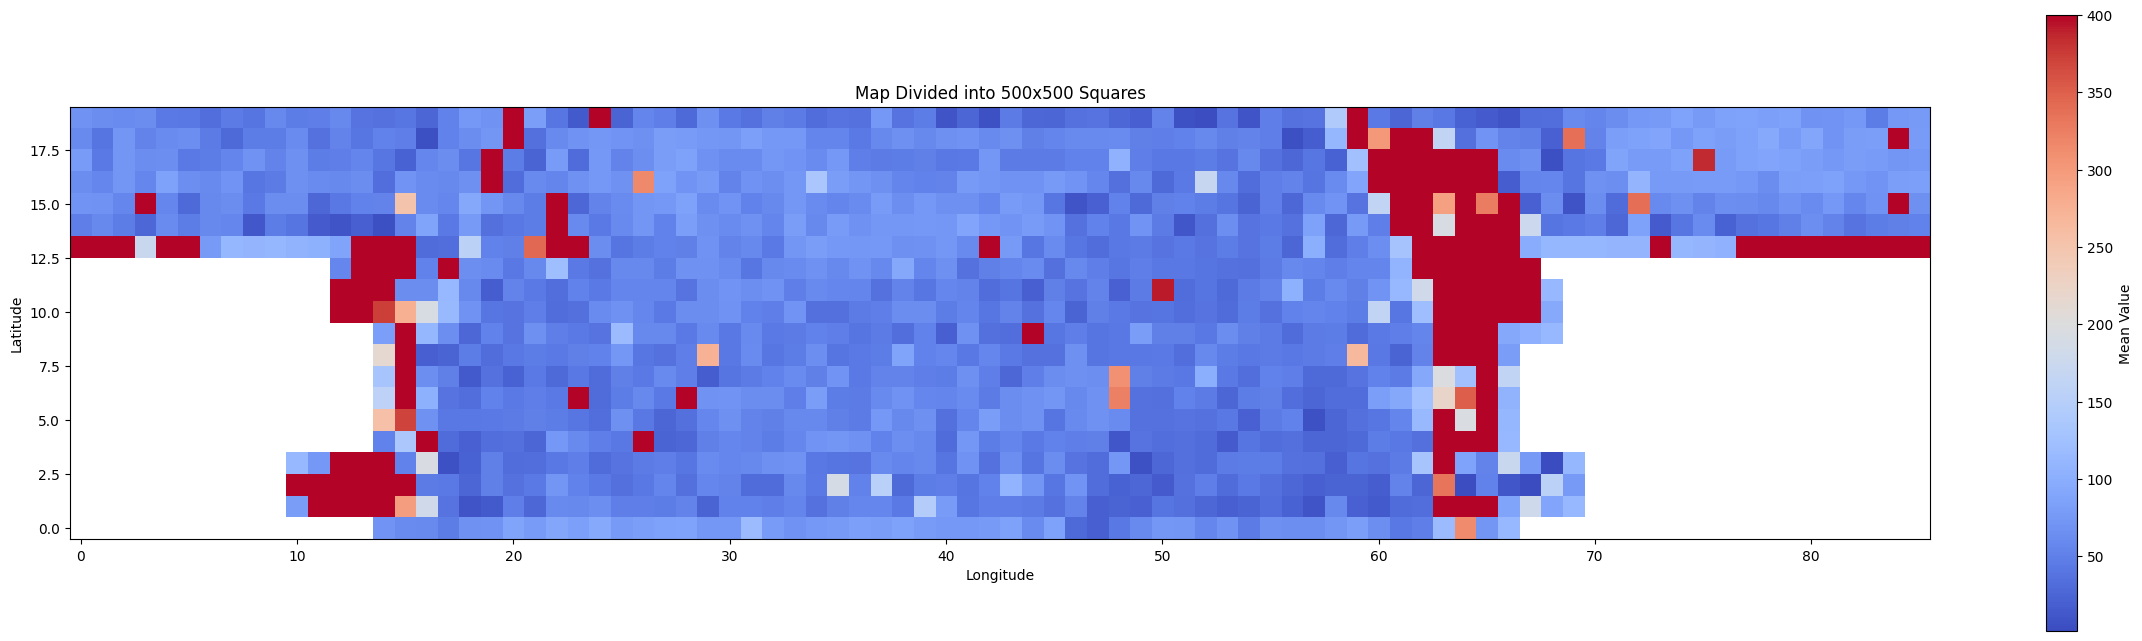

In [156]:
plt.figure(figsize=(30, 8))
plt.imshow(square_values, vmax = 400, cmap='coolwarm', origin='lower')
plt.colorbar(label='Mean Value')
plt.title('Map Divided into 500x500 Squares')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.grid(False)
plt.show()

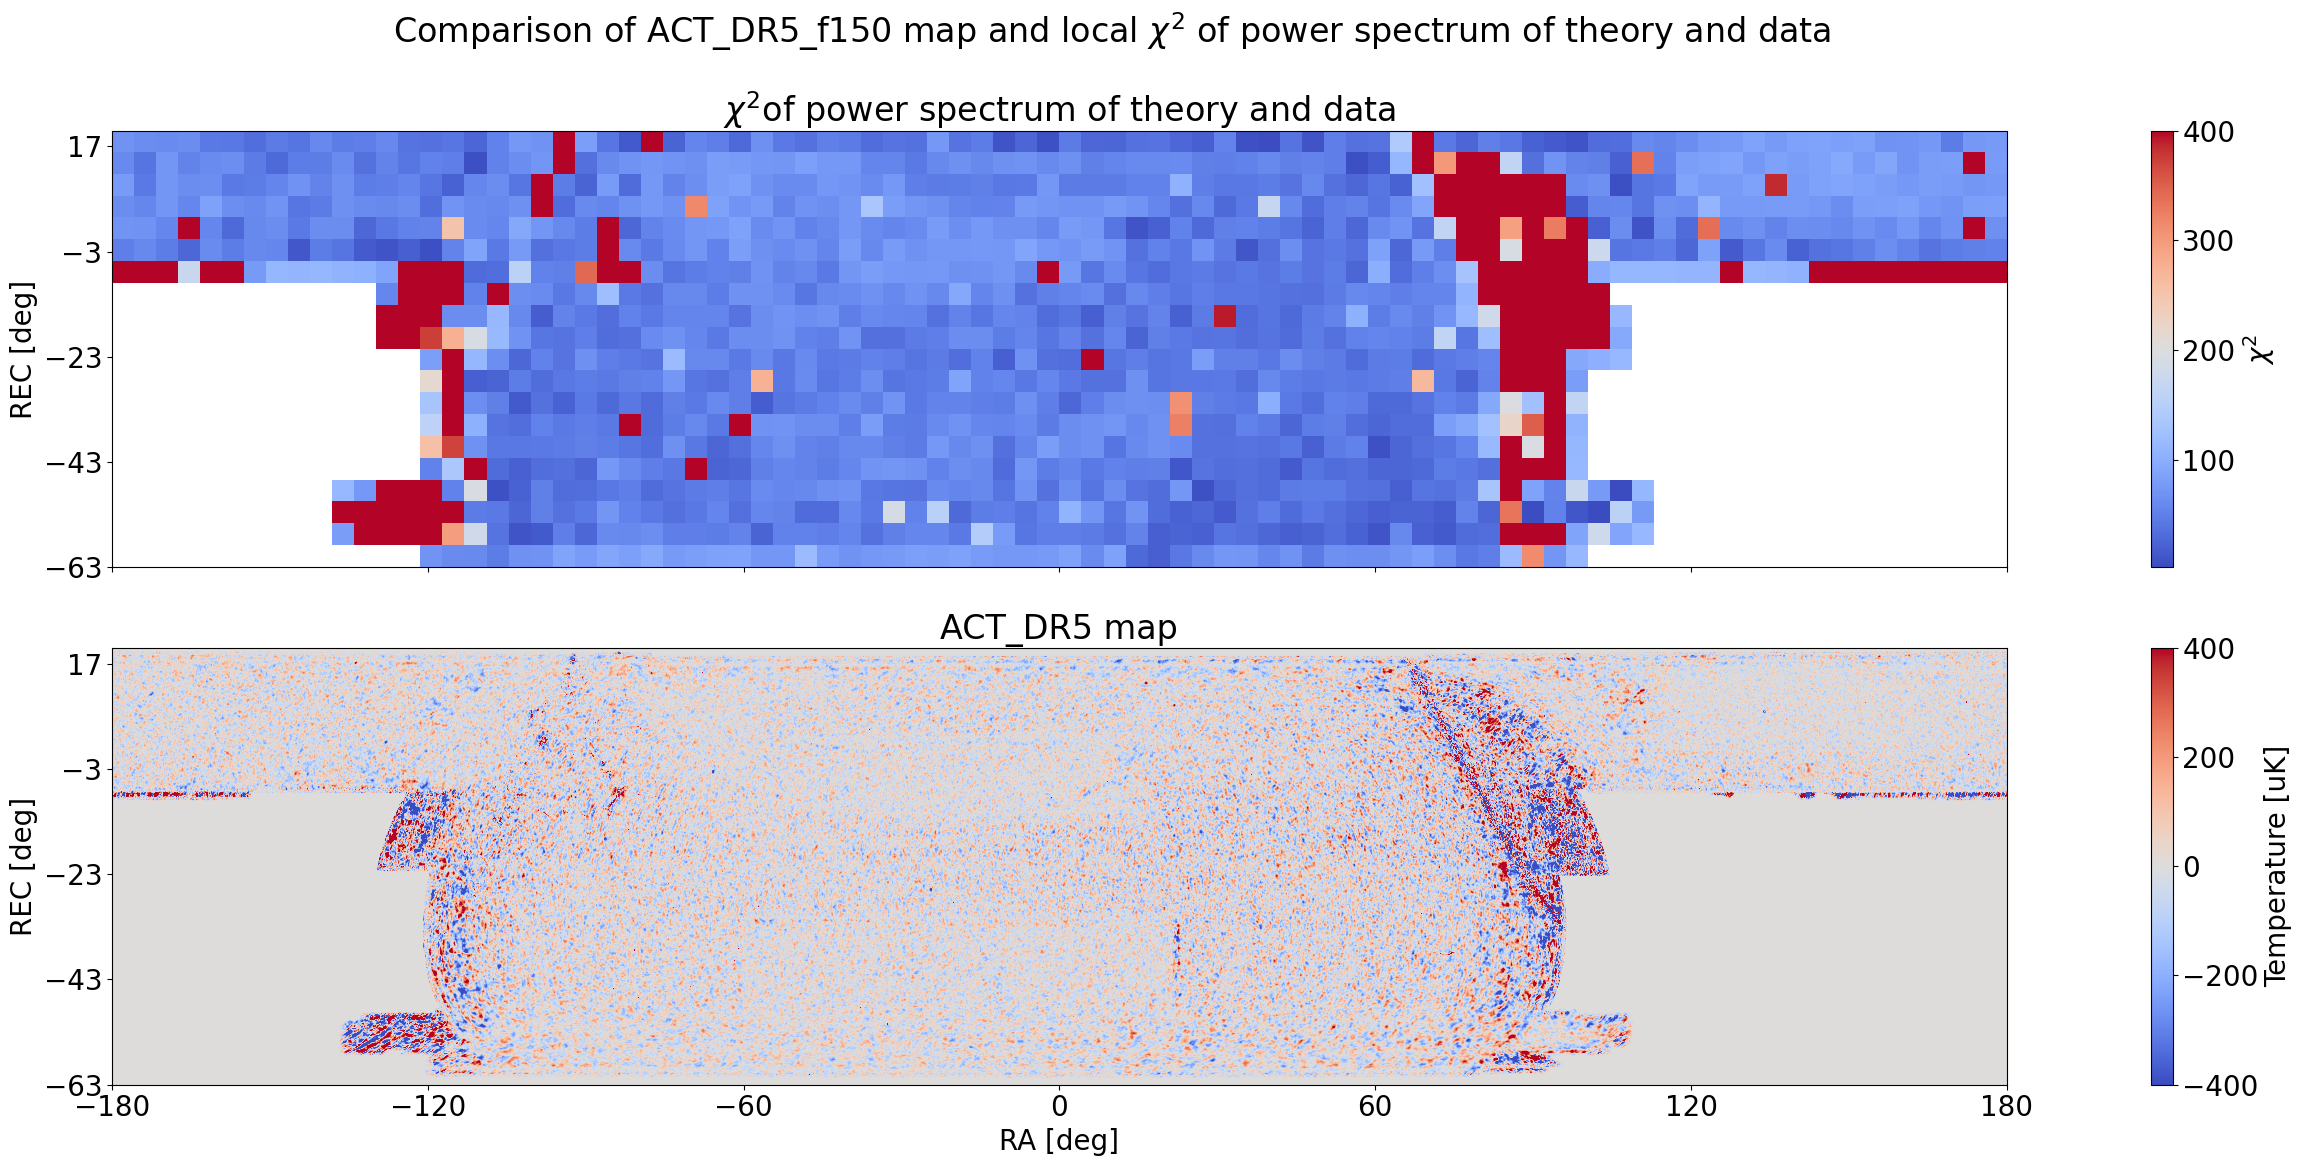

In [163]:

# Define the x and y axis limits
x_extent = (-180, 180)  # Longitude range
y_extent = (-63, 20)    # Latitude range


# Step 2: Define a figure with two subplots side by side, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 12), sharex=True)
plt.rcParams.update({'font.size': 20})
# Step 3: Plot the first map using imshow with shared x-axis
im1 = ax1.imshow(square_values, vmax = 400, cmap='coolwarm', origin='lower', extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]])
ax1.set_title('$\chi^2$of power spectrum of theory and data')
#ax1.set_xlabel('RA')
ax1.set_ylabel('REC [deg]')
plt.colorbar(im1, ax=ax1, orientation='vertical', label="$\chi^2$")

# Step 4: Plot the second map using imshow
im2 = ax2.imshow(map, vmax = 400, vmin = -400, cmap='coolwarm', origin='lower', extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]])
ax2.set_title('ACT_DR5 map')
ax2.set_xlabel('RA [deg]')
ax2.set_ylabel('REC [deg]')
plt.colorbar(im2, ax=ax2, orientation='vertical', label="Temperature [uK]")

# Step 5: Set custom x-ticks and y-ticks
x_ticks = np.arange(-180, 181, 60)  # Longitude ticks every 60 degrees
y_ticks = np.arange(-63, 21, 20)    # Latitude ticks from -63 to 20 degrees

for ax in [ax1, ax2]:
    ax.set_yticks(y_ticks)
    ax.tick_params(axis='both', labelsize=20)  # Increase tick label font size
ax2.set_xticks(x_ticks)  # Set x-ticks only on the bottom plot
ax2.tick_params(axis='x', labelsize=20)  # Increase x-tick font size

# Step 6: Adjust layout and display the plots
plt.suptitle('Comparison of ACT_DR5_f150 map and local $\chi^2$ of power spectrum of theory and data')
plt.tight_layout()
plt.show()


In [165]:
loaded_data = np.loadtxt("chisquaremap_ACT_DR5.txt", delimiter=',')